In [1]:
from astropy.table import Table
import numpy as np
import pandas as pd
import pylab as pl

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import pickle
import os

from astropy.io import fits
from astropy.table import Table
    
import src.plotting_tools as plt_tools
from src.utils import cone
import corner

pl.style.use('/pscratch/sd/j/jfsuarez/plots.mplstyle')

from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

In [2]:
from src.utils import np_unstrcuted
from src.utils import metrics
from src.utils import mw_transmission
from src.utils import mag

In [3]:
data_file = '../../data/deepgn/catalog_guadalupe_main_bgs_jpg/photo_features_full.csv'

data = Table.read(data_file)
data

<Table length=825361>
     TARGETID              Z           ... LABEL       RATIO_BA     
      int64             float64        ...  str5       float64      
----------------- -------------------- ... ----- -------------------
39627541597651211  0.10465148000721934 ... train 0.28696197271347046
39627541597651384  0.20723219232576198 ... train   0.657204806804657
39627541601845289  0.34257429377805054 ... train  0.6952996253967285
39627541606039631  0.41999844048285995 ... train 0.13739337027072906
39627541606039677   0.3323346693623744 ... train 0.48272645473480225
39627541606039880  0.22767768425646814 ...  test  0.6805657148361206
39627547490648172  0.21990599447706743 ... train  0.7098605036735535
39627547490648176  0.24034261154657718 ... train  0.6128799319267273
39627547490648342   0.0688902953313014 ... train 0.44652557373046875
39627547490648764  0.18921928265323812 ... train 0.43843013048171997
              ...                  ... ...   ...                 ...
39637330885084473    0.140182594670623 ... train 0.21901285648345947
39637330885084662   0.4681153425473922 ... train   0.851880669593811
39637330885085294   0.3456888895147781 ... train  0.4086994528770447
39637330885085953   0.4612942421895889 ... train  0.7507374286651611
39637330885086337  0.11930735257850753 ...  test 0.30655044317245483
39637330885087431  0.42164491508132684 ... train  0.5441515445709229
39637330885087784  0.16075618269700442 ...  test  0.7990790605545044
39637330885087875  0.31641716071315273 ... train  0.5470945239067078
39637341018526528 0.034248581708430356 ...  test 0.23366130888462067
39637341018526951   0.3168911376012401 ...  test  0.5707916617393494

In [4]:
data.keys()

['TARGETID',
 'Z',
 'TARGET_RA',
 'TARGET_DEC',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'EBV',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'LABEL',
 'RATIO_BA']

In [5]:
sum(data['LABEL']=='train'), sum(data['LABEL']=='test'), sum(data['LABEL']=='valid')

(577870, 164992, 82499)

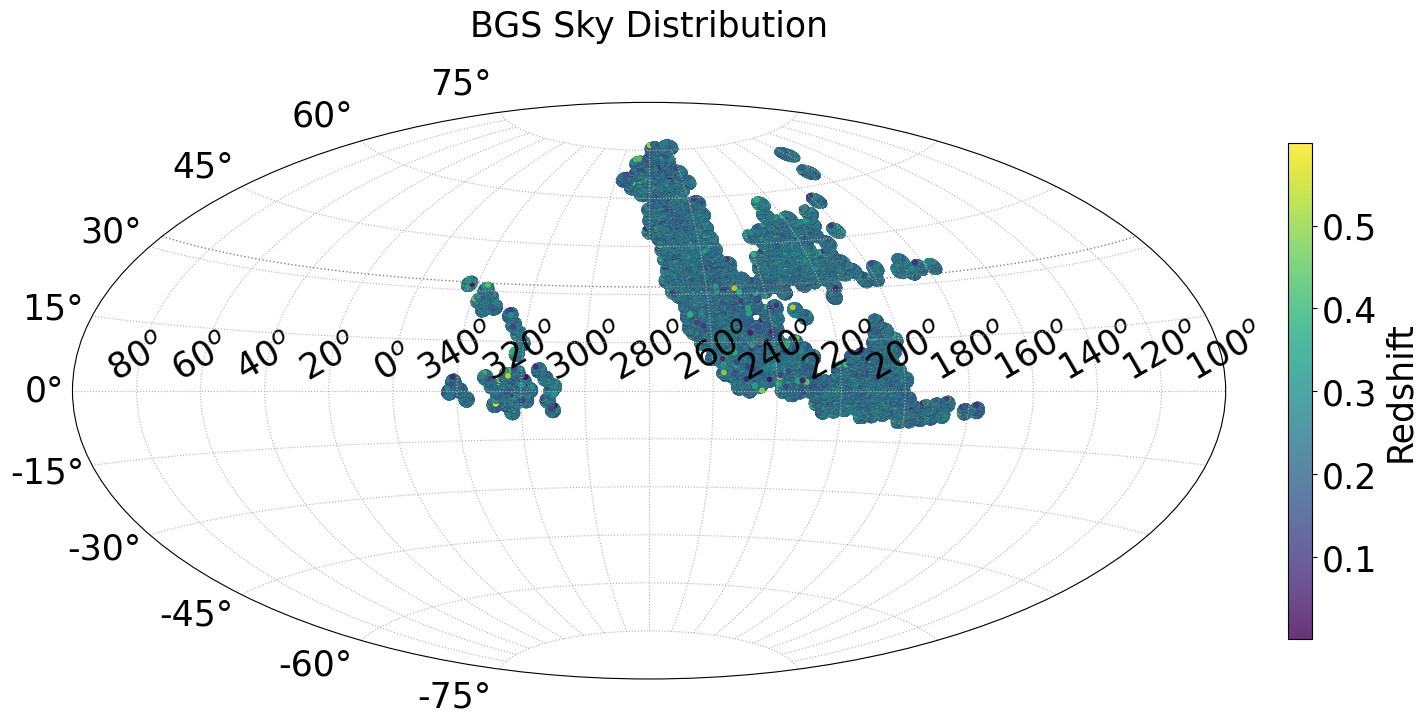

In [43]:
ii = np.array(data['Z'])<0.6
fig = plt_tools.plot_skymap(data['TARGET_RA'][ii], data['TARGET_DEC'][ii], data['Z'][ii], field_str='Redshift', title='BGS Sky Distribution', ptsize=10)   
fig.savefig('./paper_figs/fig2.1_BGSSky.png', bbox_inches='tight')
fig.savefig('./paper_figs/fig2.1_BGSSky.pdf', bbox_inches='tight')
fig.show()

146721


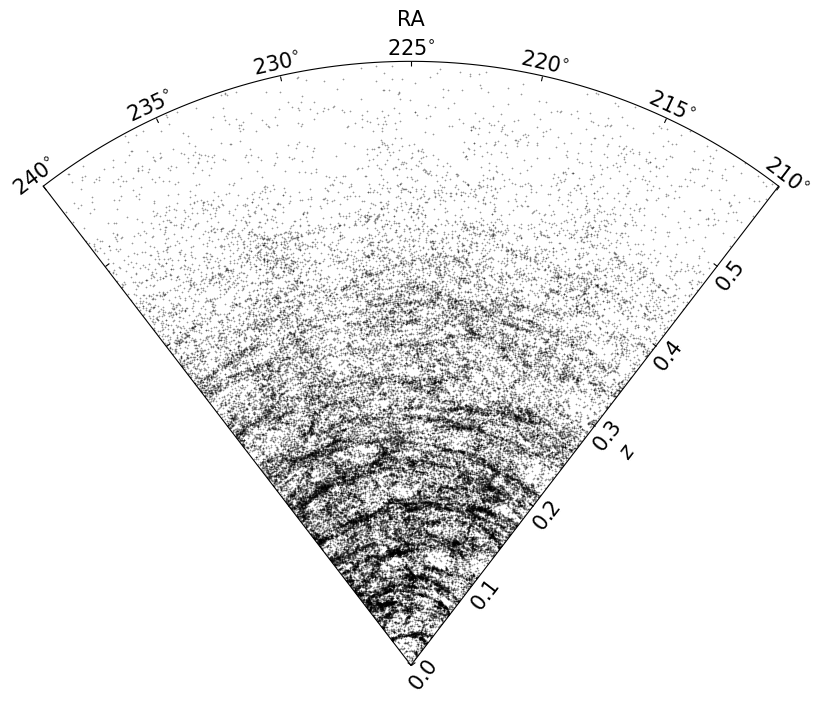

In [7]:
ii = (data['Z']<0.6) & ((data['TARGET_DEC']>30) &(data['TARGET_DEC']<40))
print(sum(ii))
fig = pl.figure(figsize=(10,8))
_ = cone(data['TARGET_RA'][ii], data['Z'][ii], scale=2.5,
                          orientation='vertical', raaxis='mid', sizes=3,
                          ralim=(210, 240), zlim=(0, 0.6),
                          hms=False, plot='scatter', fig=fig, subnum=111, 
                          xlabel='RA', ylabel=r'$z$', fontsize=15)

pl.savefig('./paper_figs/00_LSS_BGS.png', bbox_inches='tight')
pl.savefig('./paper_figs/00_LSS_BGS.pdf', bbox_inches='tight')
pl.show()

(2162, 0.2339249617199376)

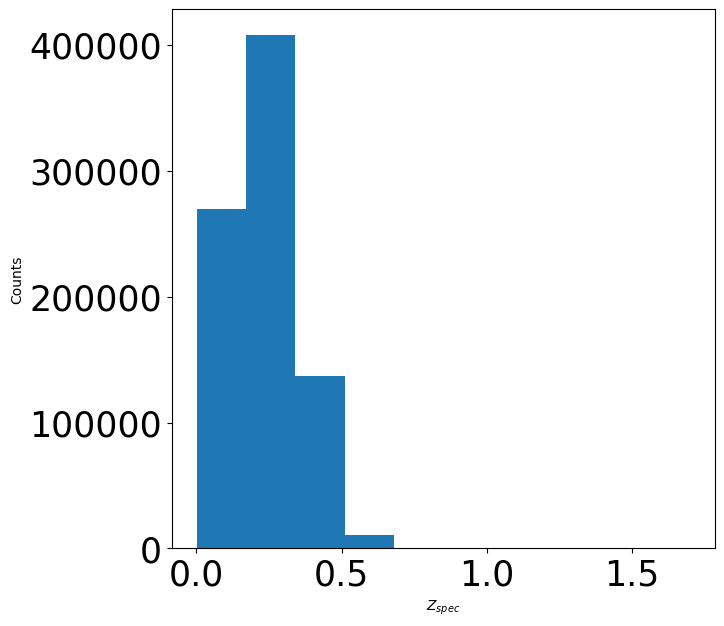

In [9]:
_ = pl.hist(data['Z'])
pl.xlabel(r'$Z_{spec}$')
pl.ylabel(r'Counts')
sum(data['Z']>0.6), np.mean(data['Z'])

In [10]:
RF_model = Table.read('./model/classic/RF_test.csv')
best_rf = RF_model[np.argmin(RF_model['sig_nmad'])]
best_rf

<Row index=24>
 col0    NE      MD           r2               sig_nmad             f_out      
int64 float64 float64      float64             float64             float64     
----- ------- ------- ------------------ -------------------- -----------------
   24   400.0    30.0 0.8415721871341044 0.012641205612459254 6.550881192887058

In [11]:
GB_model = Table.read('./model/classic/GB_test.csv')
best_gb = GB_model[np.argmax(GB_model['r2'])]
best_gb

<Row index=5>
 col0    NE      MD           r2               sig_nmad             f_out      
int64 float64 float64      float64             float64             float64     
----- ------- ------- ------------------ -------------------- -----------------
    5   115.0    10.0 0.8408096677029941 0.012662193273771672 6.503331524820317

In [12]:
# What means negative flux??
data = data[data['FLUX_W1']>0]
data = data[data['FLUX_W2']>0]

In [13]:
MAG_G    =  mag(data['FLUX_G'], data['EBV'], 'G')
MAG_R    =  mag(data['FLUX_R'], data['EBV'], 'R')
MAG_Z    =  mag(data['FLUX_Z'], data['EBV'], 'Z')
MAG_W1   =  mag(data['FLUX_W1'], data['EBV'], 'W1')
MAG_W2   =  mag(data['FLUX_W2'], data['EBV'], 'W2')
MAGG_R    =  MAG_G - MAG_R
MAGR_Z    =  MAG_R - MAG_Z
MAGZ_W1   =  MAG_Z - MAG_W1
MAGW1_W2  =  MAG_W1 - MAG_W2
HL_RADIUS = data['SHAPE_R']
RATIO_BA  = data['RATIO_BA']
Z         = data['Z']
LABEL     = data['LABEL']

In [14]:
X = Table([MAG_G, MAG_R, MAGG_R, MAGR_Z, MAGZ_W1, MAGW1_W2, HL_RADIUS, RATIO_BA], names=('MAG_G','MAG_R','MAG_G-R','MAG_R-Z','MAG_Z-W1','MAG_W2-W1','HL_RADIUS','RATIO_BA'))
Y = Table([Z], names=('Z'))

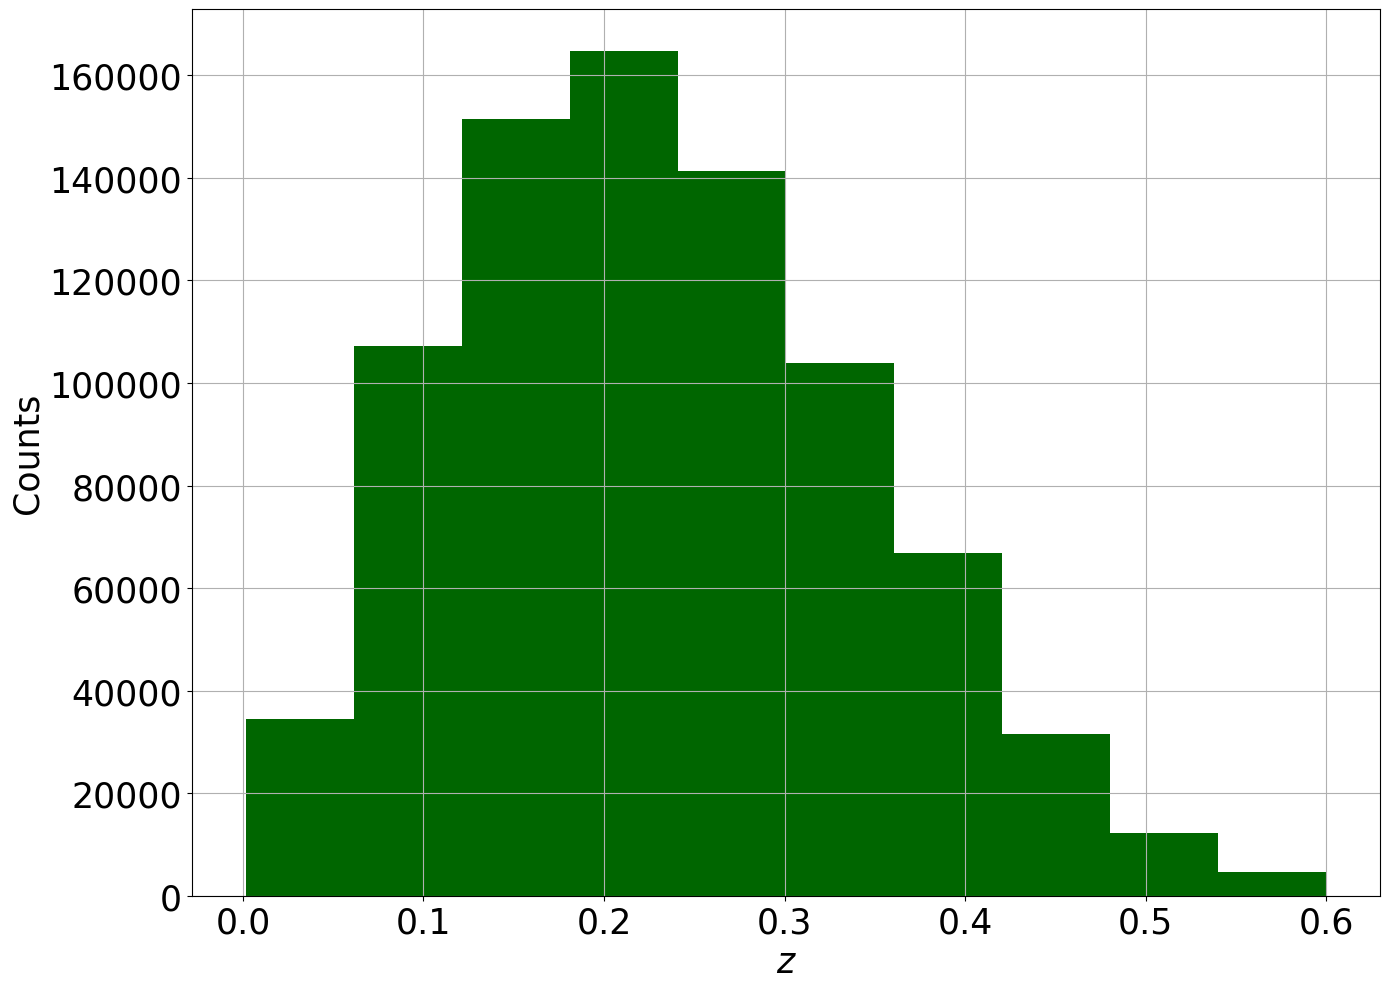

In [39]:
fig = pl.figure(figsize=(14,10), rasterized=True)
pl.hist(Y['Z'][Y['Z']<0.6], color='#006600')
pl.grid()
pl.xlabel(r'$z$', fontsize=25)
pl.ylabel(r'Counts', fontsize=25)
pl.tight_layout()
pl.savefig('./paper_figs/fig2.2_BGSZ.png', bbox_inches='tight')
pl.savefig('./paper_figs/fig2.2_BGSZ.pdf', bbox_inches='tight')
pl.show()

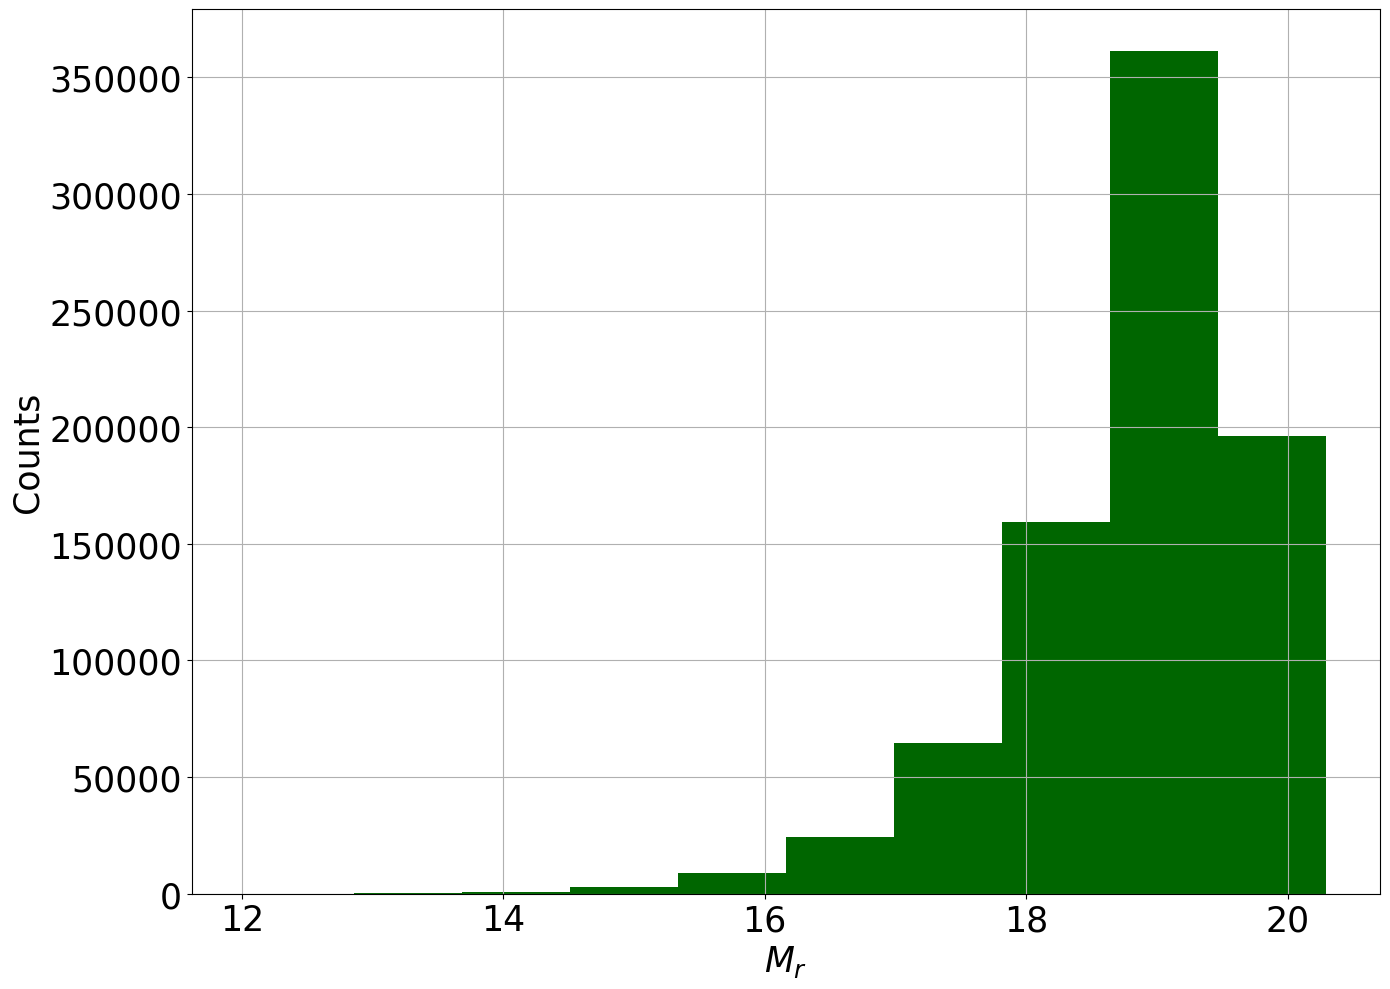

In [41]:
fig = pl.figure(figsize=(14,10), rasterized=True)
pl.hist(X['MAG_R'][Y['Z']<0.6], color='#006600')
pl.grid()
pl.xlabel(r'$M_r$', fontsize=25)
pl.ylabel(r'Counts', fontsize=25)
pl.tight_layout()
pl.savefig('./paper_figs/fig2.2_BGS_MAGR.png', bbox_inches='tight')
pl.savefig('./paper_figs/fig2.2_BGS_MAGR.pdf', bbox_inches='tight')
pl.show()

In [16]:
np.mean(Y['Z'][Y['Z']<0.6])

0.23268591778533215

In [17]:
X_train  = np_unstrcuted(X[LABEL=='train'])
Y_train  = np_unstrcuted(Y[LABEL=='train'])

X_train = X_train[Y_train<0.6]
Y_train = Y_train[Y_train<0.6]

X_test  = np_unstrcuted(X[LABEL=='test'])
Y_test  = np_unstrcuted(Y[LABEL=='test'])

# print(len(X_test)) #162469
# print(sum(Y_test>0.6)) #557


ii_z = Y_test<0.6

X_test = X_test[ii_z]
Y_test = Y_test[ii_z]
print(len(X_test), len(X_train), len(X[LABEL=='valid']), len(X))

163561 573016 81988 820454


/pscratch/sd/j/jfsuarez/DEEPGN/deepgn/src/utils.py:20: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return A.view((float, (len(A.dtype.names))))


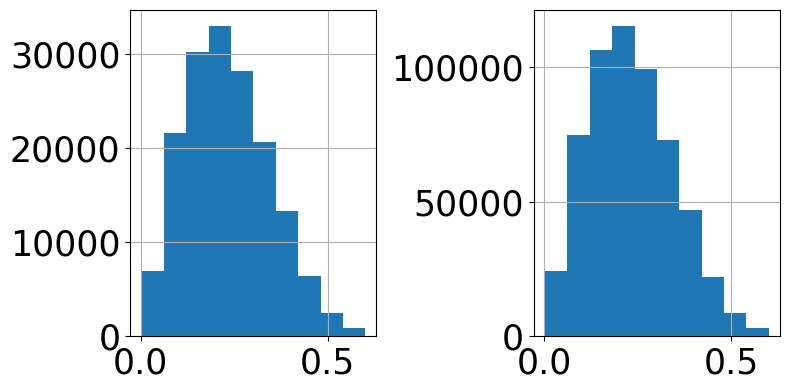

In [18]:
fig = pl.figure(figsize=(8,4))
pl.subplot(1,2,1)
pl.hist(Y_test)
pl.grid()
pl.subplot(1,2,2)
pl.hist(Y_train)
pl.grid()
pl.tight_layout()
pl.show()

In [19]:
X_test

array([[20.04451378, 19.47712339,  0.56739039, ..., -0.16869491,
         1.77716732,  0.68056571],
       [20.28961569, 18.60164676,  1.68796893, ..., -0.43844865,
         2.2986033 ,  0.46928051],
       [18.66402561, 18.10071145,  0.56331417, ...,  0.15379008,
         1.76077235,  0.50357407],
       ...,
       [20.15017929, 19.1771855 ,  0.97299379, ..., -0.49195761,
         0.73898804,  0.79907906],
       [19.6523649 , 19.24200689,  0.41035802, ..., -1.01839559,
         2.1301074 ,  0.23366131],
       [21.05511223, 19.56841553,  1.4866967 , ..., -0.43314869,
         0.70455658,  0.57079166]])

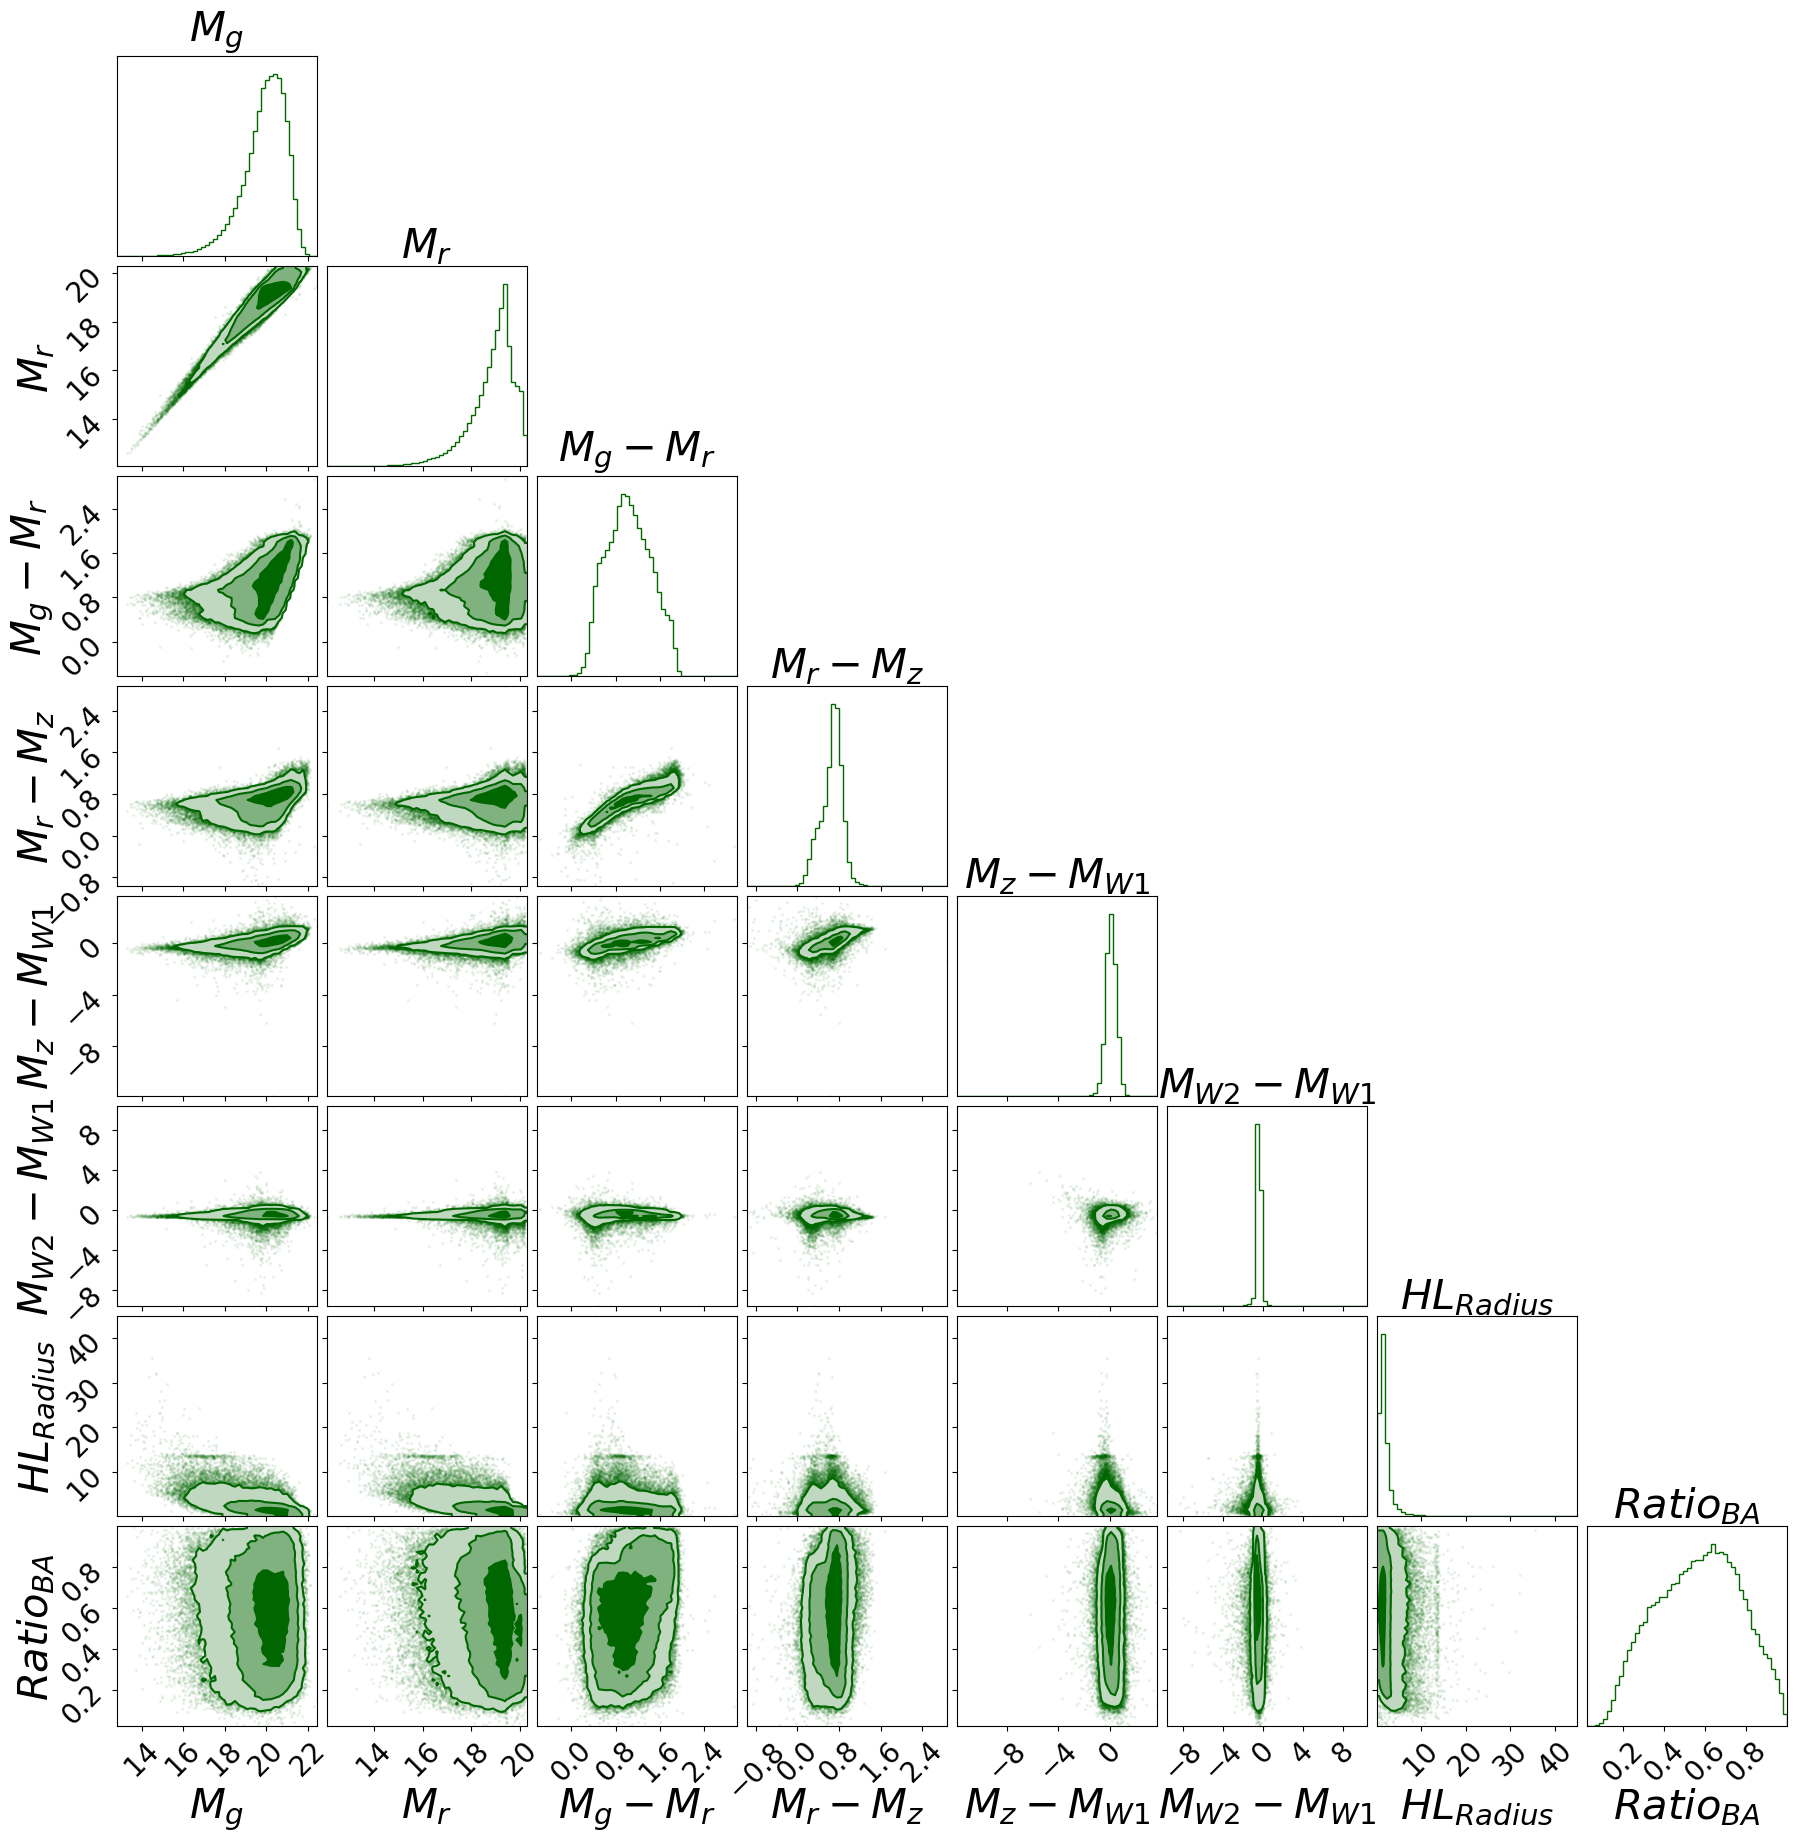

In [20]:
#ranges =[(-5,12),(0,6),(-10,17),(-10,6),(-2,2),(-15,10)]
#, range = ranges
texlabels= [r'$M_g$',r'$M_r$',r'$M_g-M_r$',r'$M_r-M_z$',r'$M_z-M_{W1}$',r'$M_{W2}-M_{W1}$',r'$HL_{Radius}$',r'$Ratio_{BA}$']
fig = corner.corner(X_test, bins=50, color="#006600", show_titles = True, labels=texlabels,
                    title_fmt=None, fill_contours=True, label_kwargs=dict(fontsize=30),
                    title_kwargs = {"fontsize": 30}, levels=[0.39, 0.86, 0.98])
for ax in fig.get_axes():
      ax.tick_params(axis = 'both', labelsize = 20)
pl.savefig('./paper_figs/fig3.0_feature_correlations.png', bbox_inches='tight', transparent=True)
pl.savefig('./paper_figs/fig3.0_feature_correlations.pdf', bbox_inches='tight', transparent=True)
pl.show()

## Random Forest

In [21]:
filename_model = f'./model/classic/rf_ne'+str(int(best_rf['NE']))+'_md'+str(int(best_rf['MD']))+'.pkl'
# filename_model = f'./modeltight_layoutne20_md10.pkl'
print(filename_model)
train = True
if (os.path.isfile(filename_model)) and not(train):
    print('Reading model file...')
    model = pickle.load(open(filename_model, "rb"))
else:
    model = RandomForestRegressor(n_estimators=int(best_rf['NE']), max_depth=int(best_rf['MD']))
    model.fit(X_train, Y_train)
model

./model/classic/rf_ne400_md30.pkl


RandomForestRegressor(max_depth=30, n_estimators=400)

In [22]:
Y_pred = model.predict(X_test)

In [23]:
np.mean(Y_pred)

0.23278842229660382

In [24]:
Z = gaussian_kde(np.vstack([Y_test, Y_pred]))(np.vstack([Y_test, Y_pred]))

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
x, y, z = Y_test[idx], Y_pred[idx], Z[idx]

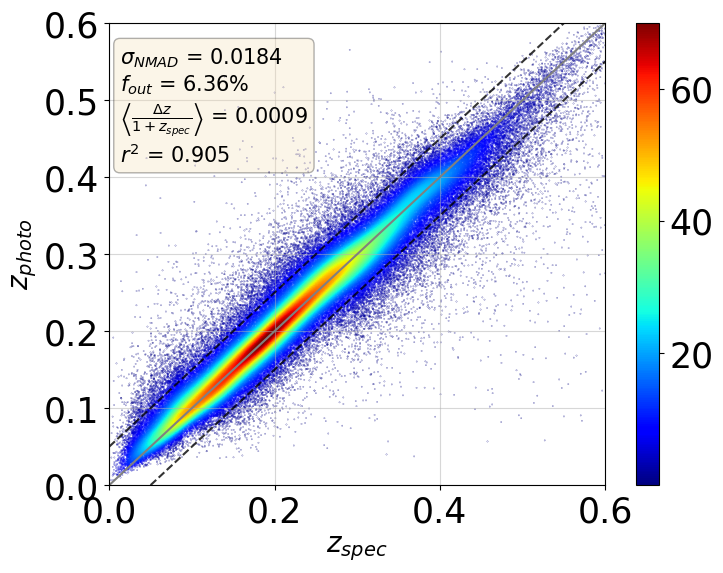

In [44]:
error = 0.05
bias, sigma_nmad, f_out = metrics(Y_test, Y_pred, error)

fig = pl.figure(figsize=(8,6), rasterized=True)

pl.scatter(x, y, c=z, s=0.1, cmap='jet', marker='.')
pl.ylabel(r'$z_{photo}$', fontsize=20)
pl.xlabel(r'$z_{spec}$', fontsize=20)
pl.colorbar()
pl.plot(np.linspace(0,2,5), np.linspace(0,2,5), ls='-', c='gray')
pl.plot(np.linspace(0,2,5)+error, np.linspace(0,2,5), '--k', alpha=0.8)
pl.plot(np.linspace(0,2,5), np.linspace(0,2,5)+error, '--k', alpha=0.8)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
text_box = r'$\sigma_{NMAD}$ = '+f'{sigma_nmad:.4f}\n'+r'$f_{out}$ = '+f'{f_out:.2f}%\n'+r'$\left<\frac{\Delta z}{1+ z_{spec}}\right>$ = 'f'{np.average(bias):.4f}\n'+r'$r^2$ = 'f'{r2_score(Y_test, Y_pred):.3f}'
pl.text(0.013, 0.57, text_box, fontsize=15, verticalalignment='top', bbox=props)
pl.xlim(0,0.6)
pl.ylim(0,0.6)
pl.grid(alpha=0.5)
pl.savefig('./paper_figs/fig3.1_PhotoZRF.png', bbox_inches='tight')
pl.savefig('./paper_figs/fig3.1_PhotoZRF.pdf', bbox_inches='tight')
pl.show()

In [45]:
intervals_Z = pd.IntervalIndex(pd.qcut(Y_test, 10).value_counts().index)
intervals_Z = list(zip(intervals_Z.left, intervals_Z.right))

intervals_R = pd.IntervalIndex(pd.qcut(MAG_R[LABEL=='test'][ii_z], 10).value_counts().index)
intervals_R = list(zip(intervals_R.left, intervals_R.right))

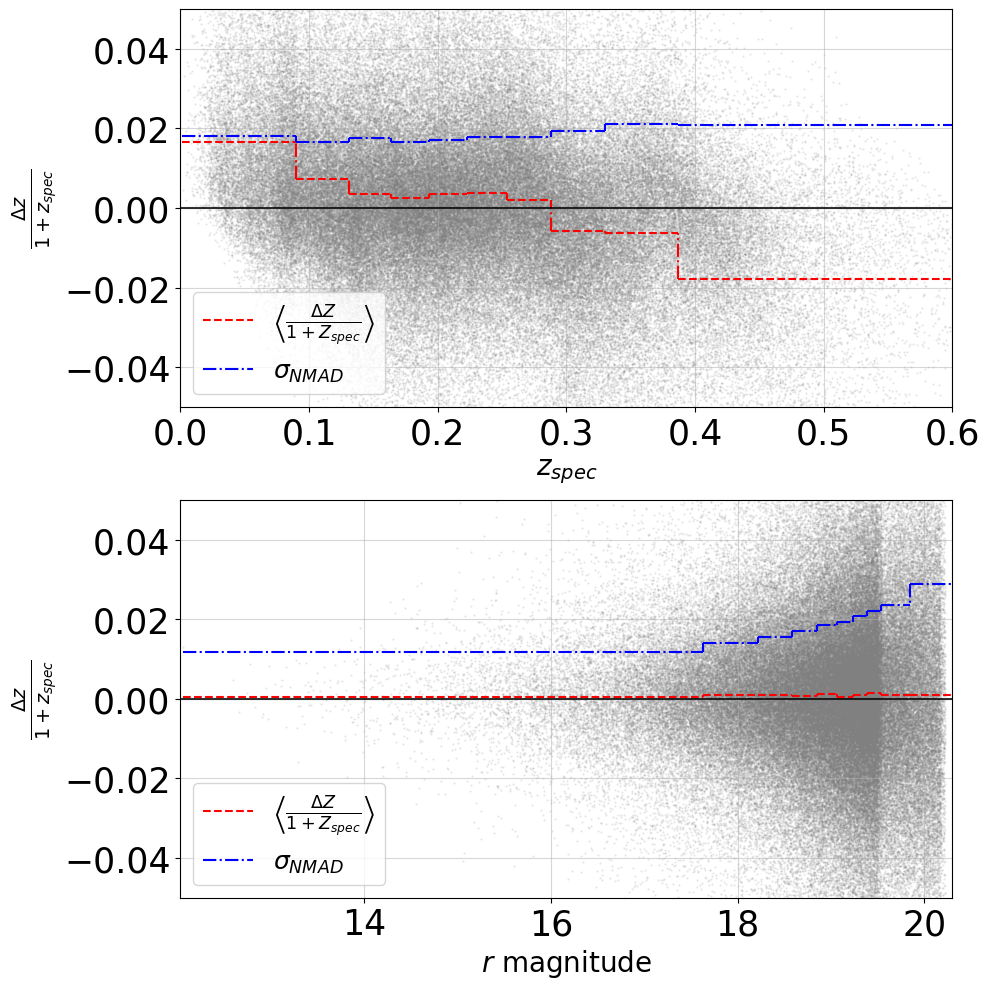

In [46]:
fig, (ax1, ax2) = pl.subplots(2, gridspec_kw={'height_ratios': [1, 1]}, figsize=(10,10))

last_bias_z = 0
last_bias_r = 0
last_sigma_z = 0
last_sigma_r = 0

for int_z , int_r in zip(intervals_Z, intervals_R):
    error = 0.05

    ii = (Y_test > int_z[0]) & (Y_test < int_z[1])
    bias, sigma_nmad, f_out = metrics(Y_test[ii], Y_pred[ii], error)
    
    pl.sca(ax1)
    ax1.hlines(y=np.mean(bias), xmin=int_z[0], xmax=int_z[1], ls='--', linewidth=1.5, color='red')
    ax1.hlines(y=sigma_nmad, xmin=int_z[0], xmax=int_z[1], ls='-.', linewidth=1.5, color='blue')
    if last_bias_z !=0:
        ax1.vlines(x=int_z[0], ymin=np.mean(bias), ymax=last_bias_z, ls='-.', linewidth=1.5, color='red')
        ax1.vlines(x=int_z[0], ymin=sigma_nmad, ymax=last_sigma_z, ls='-.', linewidth=1.5, color='blue')
    last_bias_z = np.mean(bias)
    last_sigma_z = sigma_nmad

    ii = (MAG_R[LABEL=='test'][ii_z] > int_r[0]) & (MAG_R[LABEL=='test'][ii_z] < int_r[1])
    bias, sigma_nmad, f_out = metrics(Y_test[ii], Y_pred[ii], error)
    
    pl.sca(ax2)
    ax2.hlines(y=np.mean(bias), xmin=int_r[0], xmax=int_r[1], ls='--', linewidth=1.5, color='red')
    ax2.hlines(y=sigma_nmad, xmin=int_r[0], xmax=int_r[1], ls='-.', linewidth=1.5, color='blue')
    if last_bias_r !=0:
        ax2.vlines(x=int_r[0], ymin=np.mean(bias), ymax=last_bias_r, ls='-.', linewidth=1.5, color='red')
        ax2.vlines(x=int_r[0], ymin=sigma_nmad, ymax=last_sigma_r, ls='-.', linewidth=1.5, color='blue')
    last_bias_r = np.mean(bias)
    last_sigma_r = sigma_nmad
    
    
    
pl.sca(ax1)    
ax1.hlines(y=0, xmin=0, xmax=0.6, ls='-', linewidth=1.5, color='black', alpha=0.8)   
ax1.hlines(y=0, xmin=0, xmax=0, ls='--', linewidth=1.5, color='red', label=r'$\left<\frac{\Delta Z}{1+ Z_{spec}}\right>$') 
ax1.hlines(y=0, xmin=0, xmax=0, ls='-.', linewidth=1.5, color='blue', label=r'$\sigma_{NMAD}$') 
bias, sigma_nmad, f_out = metrics(Y_test, Y_pred, error)
pl.scatter(Y_test, bias, s=1, marker='.', color='gray', alpha=0.2)    
pl.ylabel(r'$\frac{\Delta z}{1+ z_{spec}}$', fontsize=20)
pl.xlabel(r'$z_{spec}$', fontsize=20)
pl.grid(alpha=0.5)
pl.legend()
pl.legend(loc=3, fontsize=18)
pl.ylim(-0.05,0.05)
pl.xlim(0,0.6)

pl.sca(ax2)
ax2.hlines(y=0, xmin=min(MAG_R), xmax=max(MAG_R), ls='-', linewidth=1.5, color='black', alpha=0.8)    
ax2.hlines(y=0, xmin=0, xmax=0, ls='--', linewidth=1.5, color='red', label=r'$\left<\frac{\Delta Z}{1+ Z_{spec}}\right>$') 
ax2.hlines(y=0, xmin=0, xmax=0, ls='-.', linewidth=1.5, color='blue', label=r'$\sigma_{NMAD}$') 
pl.scatter(MAG_R[LABEL=='test'][ii_z], bias, s=1, marker='.', color='gray', alpha=0.2)
pl.ylabel(r'$\frac{\Delta z}{1+ z_{spec}}$', fontsize=20)
pl.xlabel(r'$r$ magnitude', fontsize=20)
pl.grid(alpha=0.5)
pl.legend(loc=3, fontsize=18)
pl.ylim(-0.05,0.05)
pl.xlim(min(MAG_R), max(MAG_R))

pl.tight_layout()
pl.savefig('./paper_figs/fig3.2_PhotoZRF_biasmag.png', bbox_inches='tight')
pl.savefig('./paper_figs/fig3.2_PhotoZRF_biasmag.pdf', bbox_inches='tight')
pl.show()

0.0009175370295195466 0.0007432287053369238 0.027262221210622654


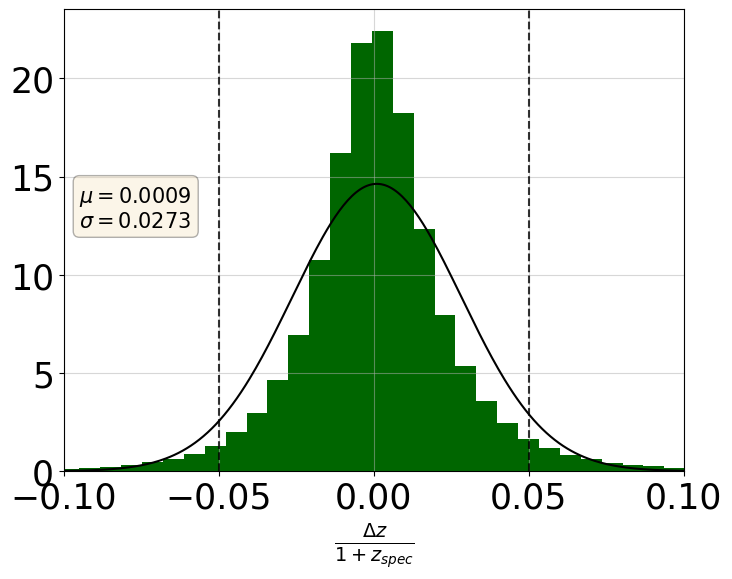

In [47]:
fig = pl.figure(figsize=(8,6), rasterized=True)

_ = pl.hist(bias, bins=100, density=True, color='#006600')
avg = np.mean(bias)
var = np.var(bias)
std = np.std(bias)

# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(np.min(bias),np.max(bias),1000)
pdf_y = 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

pl.axvline(0.05, alpha=0.8, linestyle='--', c='k')
pl.axvline(-0.05, alpha=0.8, linestyle='--', c='k')
pl.xlabel(r'$\frac{\Delta z}{1+ z_{spec}}$', fontsize=20)
pl.plot(pdf_x, pdf_y, 'k-')

print(avg, var, std)

pl.xlim(-0.1,0.1)
text_box = fr'$\mu=${avg:.4f}'+ f'\n' + fr'$\sigma=${std:.4f}'
pl.text(-0.095, max(pdf_y), text_box, fontsize=15, verticalalignment='top', bbox=props)
pl.grid(alpha=0.5)
pl.savefig('./paper_figs/fig3.3_PhotoZRF_biasfit.png', bbox_inches='tight')
pl.savefig('./paper_figs/fig3.3_PhotoZRF_biasfit.pdf', bbox_inches='tight')
pl.show()

In [48]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
print(importances)

[0.20128538 0.01169874 0.07533077 0.03929983 0.51810162 0.03876035
 0.03933604 0.07618727]


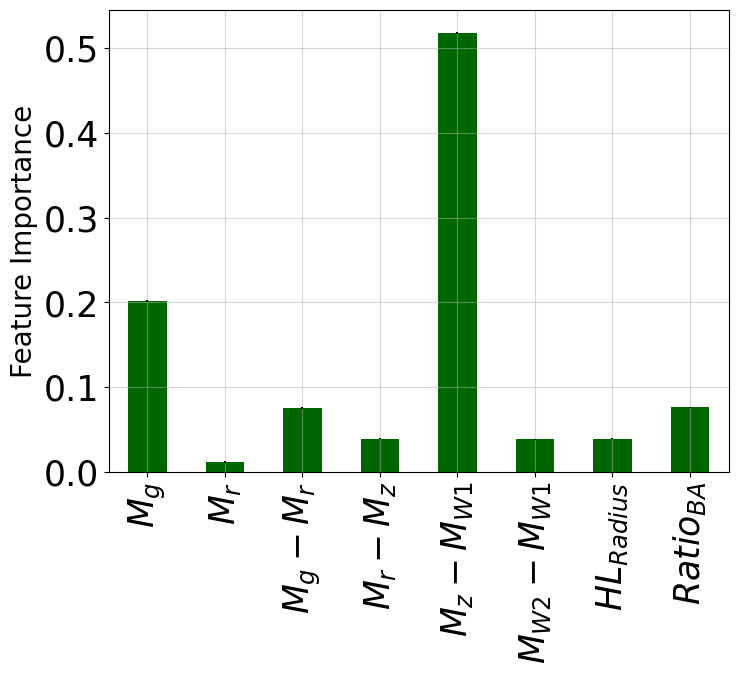

In [49]:
feature_names= [r'$M_g$',r'$M_r$',r'$M_g-M_r$',r'$M_r-M_z$',r'$M_z-M_{W1}$',r'$M_{W2}-M_{W1}$',r'$HL_{Radius}$',r'$Ratio_{BA}$']
model_importances = pd.Series(importances, index=feature_names)

fig = pl.figure(figsize=(8,6), rasterized=True)
ax = pl.gca()
model_importances.plot.bar(yerr=std, ax=ax, color='#006600')
pl.ylabel("Feature Importance", fontsize=20)
pl.grid(alpha=0.5)
pl.savefig('./paper_figs/fig3.4_PhotoZRF_importances.png', bbox_inches='tight')
pl.savefig('./paper_figs/fig3.4_PhotoZRF_importances.pdf', bbox_inches='tight')
pl.show()

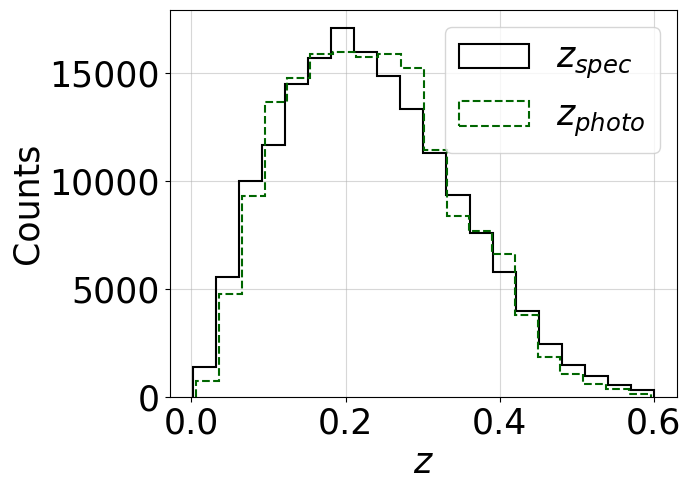

In [50]:
fig = pl.figure(figsize=(7,5), rasterized=True)
pl.hist(Y_test, color='black', bins=20, label=r'$z_{spec}$', histtype='step', linestyle='solid', linewidth=1.5)
pl.hist(Y_pred, color='#006600', ls='-', bins=20, label=r'$z_{photo}$', histtype='step', linestyle='--', linewidth=1.5)
pl.grid(alpha=0.5)
pl.xlabel(r'$z$', fontsize=25)
pl.ylabel(r'Counts', fontsize=25)
pl.tight_layout()
pl.legend()
pl.savefig('./paper_figs/fig3.5_BGSZpredDist.png', bbox_inches='tight')
pl.savefig('./paper_figs/fig3.5_BGSZpredDist.pdf', bbox_inches='tight')
pl.show()

In [51]:
bias, sigma_nmad, f_out = metrics(Y_test, Y_pred, error)

In [52]:
Tbias_test =Table(np.c_[ (bias, data['TARGETID'][LABEL=='test'][ii_z], data['TARGET_RA'][LABEL=='test'][ii_z], data['TARGET_DEC'][LABEL=='test'][ii_z]) ], names=['BIAS','TARGETID','TARGET_RA','TARGET_DEC'])
Tbias_test

<Table length=163561>
         BIAS                 TARGETID        ...      TARGET_DEC    
       float64                float64         ...       float64      
---------------------- ---------------------- ... -------------------
  -0.03182331691467394  3.962754160603988e+16 ...  -10.15822803578794
 0.0037327665174280724 3.9627547490650104e+16 ...  -9.886233884577031
 -0.033051413760725165 3.9627547494844104e+16 ...   -9.93708807324288
 -0.004584045166749068  3.962754752839993e+16 ...  -9.917610792381836
  -0.02481974759426186  3.962754753678585e+16 ...  -9.984738402523618
  0.027040231085339254   3.96275475367859e+16 ... -10.045274815519353
 -0.055227918332778986  3.962754753678666e+16 ...  -9.963523817308674
 0.0009542946789978966  3.962754754098029e+16 ... -10.014389482994453
   0.00734782153845073  3.962754754517662e+16 ...  -9.986795959409738
    0.1300680943788639  3.962754754517688e+16 ... -10.080682331028004
                   ...                    ... ...                 ...
  0.010008731180710426  3.963732453490969e+16 ...   32.18334801085051
  0.006380876686385088  3.963732453491011e+16 ...   32.18824130713209
 -0.007501969653974221  3.963732453491111e+16 ...  32.247343367708694
-0.0029828303813400317   3.96373257848115e+16 ...  32.161493696979235
 -0.021995787517630292 3.9637325784813416e+16 ...  32.325192443215315
  0.014871397600267584  3.963732578481442e+16 ...   32.36059223209432
 -0.010760434235876234  3.963733088508634e+16 ...  32.580044027400696
  0.008457029683647598 3.9637330885087784e+16 ...   32.46413463675095
  0.017280153740521054  3.963734101852653e+16 ...  32.931316000679466
  -0.01096989603863357  3.963734101852695e+16 ...   32.89738130402283

In [53]:
Tbias_test.write('./model/classic/RFtest_bias.csv', overwrite=True)